In [170]:
from scipy.integrate import solve_ivp
import torch
from torch import nn
import torch.optim as optim
import torch.nn as nn
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

from timeit import default_timer as tdt
import torch.nn.init as init

from softadapt import SoftAdapt, NormalizedSoftAdapt, LossWeightedSoftAdapt

if torch.cuda.is_available():
    my_device = 'cuda' # I think I may have broken the cuda version
else:
    my_device = 'cpu'
    


In [171]:
# Time setup
n_days = 200
t_num = torch.linspace(0, n_days, 1001)

## Disease setup
alpha_SIR = 0.3333333
beta_SIR = 0.5

# Initial conditions
# 9.99999833e-01, 1.66666667e-07, 0.00000000e+00
N = 1.0    # Population size
I0_num = 1.66666667e-07
R0_num = 0.00000000e+00
S0_num = 1 - I0_num - R0_num    # Initial number of susceptible

In [172]:
# Solve numerically
def SIR_model_num(t, y, beta_SIR, alpha_SIR):
    S, I, R = y
    dSdt = -beta_SIR * S * I
    dIdt = beta_SIR * S * I - alpha_SIR * I
    dRdt = alpha_SIR * I
    return [dSdt, dIdt, dRdt]

# Setup initial conditions 
y0 = [S0_num, I0_num, R0_num]

# Solve using LSODA method from scipy
sol = solve_ivp(SIR_model_num, [t_num[0], t_num[-1]], y0, args=(beta_SIR, alpha_SIR), t_eval=t_num, method='LSODA')

S_data = torch.tensor(sol.y[0])
I_data = torch.tensor(sol.y[1])
R_data = torch.tensor(sol.y[2])
print(sol.message)

The solver successfully reached the end of the integration interval.


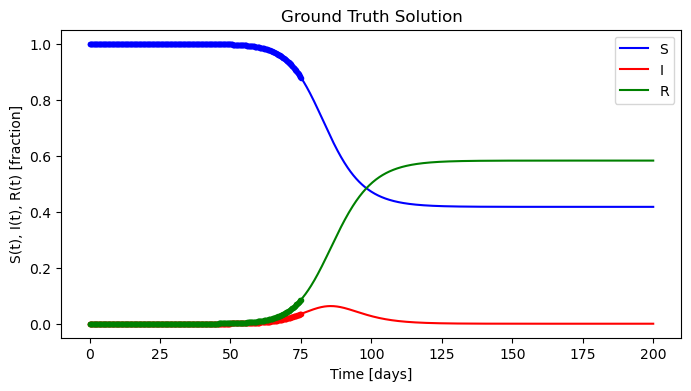

In [173]:
# Plot numerical solution
def plot_solution(t, S, I, R, title=''):
    t = t.clone().detach()
    S = S.clone().detach()
    I = I.clone().detach()
    R = R.clone().detach()
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.plot(t, S, label='S', color='blue')
    ax.plot(t, I, label='I', color='red')
    ax.plot(t, R, label='R', color='green')

    ax.set_xlabel('Time [days]')
    ax.set_ylabel('S(t), I(t), R(t) [fraction]')
    ax.legend()
    ax.set_title(title)
    
    return fig, ax
    
fig, ax = plot_solution(t_num, S_data, I_data, R_data, 'Ground Truth Solution')

# Picking some points
t_data_points = t_num[0:376:1]
S_data_points = S_data[0:376:1]
I_data_points = I_data[0:376:1]
R_data_points = R_data[0:376:1]
ax.plot(t_data_points, S_data_points, linestyle='', marker='.', color='blue')
ax.plot(t_data_points, I_data_points, linestyle='', marker='.', color='red')
ax.plot(t_data_points, R_data_points, linestyle='', marker='.', color='green')

In [174]:
def monitor_plot():
    # Setup monitor plot that runs concurrently with training loop to illustrate: loss, adaptive weights, the network vs ground truth result
    # and in the bottom right the rhs of each equation and the derivative. These should of course be similar in a perfect world.
    fig, ax = plt.subplots(2, 2, figsize=(12,8))
    # Plot losses
    line_loss_total, = ax[0,0].plot([0.5,1], [0.5,1], color='k', label='Total Loss')
    line_loss_ode, = ax[0,0].plot([0.5,1], [0.5,1], color='red', label='ODE Loss', linestyle='--')
    line_loss_ic, = ax[0,0].plot([0.5,1], [0.5,1], color='blue', label='IC Loss', linestyle='--')
    line_loss_data, = ax[0,0].plot([0.5,1], [0.5,1], color='green', label='Data Loss', linestyle='--')
    ax[0,0].legend()
    ax[0,0].set_xlabel('Epochs')
    ax[0,0].set_ylabel('Loss')
    ax[0,0].set_yscale('log')

    # Plot ground truth next to solution from network
    ax[0,1].plot(t_num.detach(), S_data.detach(), color='blue', alpha=0.5, marker='', linestyle='-', label='S_truth')
    ax[0,1].plot(t_num.detach(), I_data.detach(), color='red', alpha=0.5, marker='', linestyle='-', label='I_truth')
    ax[0,1].plot(t_num.detach(), R_data.detach(), color='green', alpha=0.5, marker='', linestyle='-', label='R_truth')
    line_S, = ax[0,1].plot([0.5,1], [0.5,1], color='lightblue', linestyle='', label='S_net', marker='.')
    line_I, = ax[0,1].plot([0.5,1], [0.5,1], color='coral', linestyle='', label='I_net', marker='.')
    line_R, = ax[0,1].plot([0.5,1], [0.5,1], color='lightgreen', linestyle='', label='R_net', marker='.')
    ax[0,1].legend()
    ax[0,1].set_xlabel('Time [days]')
    ax[0,1].set_ylabel('S, I, R - (t)')

    # Adaptive weights plot
    line_aw0, = ax[1,0].plot([0.5,1], [0.5,1], color='red', linestyle='-', label='aw[0]')
    line_aw1, = ax[1,0].plot([0.5,1], [0.5,1], color='blue', linestyle='-', label='aw[1]')
    ax[1,0].set_ylabel('Adaptive Weights')
    ax[1,0].legend()
    
    # RHS and derivative plot
    line_dSdt, = ax[1,1].plot([0.5,1], [0.5,1], color='blue', linestyle='', label='dSdt', marker='.')
    line_dIdt, = ax[1,1].plot([0.5,1], [0.5,1], color='red', linestyle='', label='dIdt', marker='.')
    line_dRdt, = ax[1,1].plot([0.5,1], [0.5,1], color='green', linestyle='', label='dRdt', marker='.')

    line_RHS_S, = ax[1,1].plot([0.5,1], [0.5,1], color='lightblue', linestyle='', label='rhs_S', marker='.')
    line_RHS_I, = ax[1,1].plot([0.5,1], [0.5,1], color='coral', linestyle='', label='rhs_I', marker='.')
    line_RHS_R, = ax[1,1].plot([0.5,1], [0.5,1], color='lightgreen', linestyle='', label='rhs_R', marker='.')
    ax[1,1].set_title('RHS and derivative comparison')
    ax[1,1].set_xlim(0,1000)
    ax[1,1].set_ylim(0,1)
    ax[1,1].set_xlabel('Time [days]')
    ax[1,1].legend()
    
    plt.tight_layout()
    return fig, ax, line_loss_total, line_loss_ode, line_loss_ic, line_loss_data, line_S, line_I, line_R, line_RHS_S, line_RHS_I, line_RHS_R, line_dSdt, line_dIdt, line_dRdt, line_aw0, line_aw1

In [175]:
# Defining loss functions

def smooth_thresholding(loss, threshold, steepness):
    # Smooth thresholding for looseining the initial condition requirement
    shifted_loss = steepness * (loss - threshold)
    return torch.sigmoid(shifted_loss) - torch.sigmoid(-steepness * threshold)

torch_MSE_loss = torch.nn.MSELoss()

def get_loss_ode(t, net, beta_SIR, alpha_SIR):
    # Calculate net solution
    S, I, R = net(t)
    
    # Use autograd to get derivatives. Divide by 1000 since the network has normalized time between [0,1] where real time it [0,1000]
    dSdt = 1.0/n_days*torch.autograd.grad(S, t, grad_outputs=torch.ones_like(S), create_graph=True)[0]
    dIdt = 1.0/n_days*torch.autograd.grad(I, t, grad_outputs=torch.ones_like(I), create_graph=True)[0]
    dRdt = 1.0/n_days*torch.autograd.grad(R, t, grad_outputs=torch.ones_like(R), create_graph=True)[0]

    # Calculate MSE loss
    rhs_S = -beta_SIR * S * I
    loss_S = torch_MSE_loss(dSdt, rhs_S)
    
    rhs_I = beta_SIR * S * I - alpha_SIR * I
    loss_I = torch_MSE_loss(dIdt, rhs_I)
    
    rhs_R = alpha_SIR * I
    loss_R = torch_MSE_loss(dRdt, rhs_R)
    
    # Sum the errors
    loss = loss_S + loss_I + loss_R
    
    return loss, S, I, R, dSdt, dIdt, dRdt, rhs_S, rhs_I, rhs_R

def get_loss_data(t, net, S_truth, I_truth, R_truth):
    
    # Reshaping
    t = t.view(-1,1) / 1000.0
    S_truth = S_truth.view(-1,1)
    I_truth = I_truth.view(-1,1)
    R_truth = R_truth.view(-1,1)
    
    # Calculate net solution
    S, I, R = net(t)
    
    # MSE loss between net result and truth
    loss_S = torch_MSE_loss(S, S_truth)
    loss_I = torch_MSE_loss(I, I_truth)
    loss_R = torch_MSE_loss(R, R_truth)
    
    # Sum loss
    loss = loss_S + loss_I + loss_R
    
    return loss

def get_loss_initial_condition(t, net, S_truth, I_truth, R_truth):
    # This is the same as the get_data loss but we can add thresholding to lower the sensitivity to the exact initial condition.
    # Reshaping
    t = t.view(-1,1) / n_days
    S_truth = S_truth.view(-1,1)
    I_truth = I_truth.view(-1,1)
    R_truth = R_truth.view(-1,1)
    
    # Calculate net solution
    S, I, R = net(t)
    
    # MSE loss between net result and truth
    diff_S = (S - S_truth).abs()
    loss_S = torch_MSE_loss(S, S_truth) * smooth_thresholding(diff_S, torch.tensor(0.1), torch.tensor(50.0)).squeeze()
    diff_I = (I - I_truth).abs()
    loss_I = torch_MSE_loss(I, I_truth) * smooth_thresholding(diff_I, torch.tensor(0.1), torch.tensor(50.0)).squeeze()
    diff_R = (R - R_truth).abs()
    loss_R = torch_MSE_loss(R, R_truth) * smooth_thresholding(diff_R, torch.tensor(0.1), torch.tensor(50.0)).squeeze()
    
    # Sum loss
    loss = loss_S + loss_I + loss_R
    
    return loss

def get_loss_for_not_correct_number_of_people(t, net):
    # Find network solution
    S, I, R = net(t)
    
    ## Adding loss for negative number of people
    loss = torch.tensor(0.0, dtype=torch.float64, device=my_device)
    out_of_bounds_saved = []
    for value in [S, I, R]:
        out_of_bounds = torch.where((value < 0.0) | (value > 1.0), value, torch.tensor(0.0, device=my_device, dtype=torch.float64))
        out_of_bounds_saved.append(out_of_bounds)
        loss += torch_MSE_loss(out_of_bounds, torch.zeros_like(out_of_bounds, device=my_device, dtype=torch.float64))
    
    return loss, out_of_bounds_saved

def get_loss_for_not_correct_number_of_people_new(t, net):
    S, I, R = net(t)

    # Stack the tensors for vectorized operations
    stacked_values = torch.stack([S, I, R])

    # Vectorized computation of out-of-bounds
    out_of_bounds = torch.where((stacked_values < 0.0), stacked_values, torch.tensor(0.0, device=my_device, dtype=torch.float64))

    # Calculate MSE loss in a vectorized way and sum across the stacked dimension
    loss = torch_MSE_loss(out_of_bounds, torch.zeros_like(out_of_bounds)).sum(dim=0)

    # Unstack to get the individual out_of_bounds tensors as per original format
    out_of_bounds_saved = list(torch.unbind(out_of_bounds))

    return loss, out_of_bounds_saved



In [176]:
# ================== Defining the network(s) ==================
class FFN(nn.Module):
    def __init__(self, input_size, hidden_layers_size, output_size):
        super(FFN, self).__init__()
        
        n_layers = len(hidden_layers_size)
        HL = hidden_layers_size
        
        # Define layers
        self.L1 = nn.Linear(input_size, HL[0]).double()
        self.L2 = nn.Linear(HL[0], HL[1]).double()
        self.L3 = nn.Linear(HL[1], HL[2]).double()
        #self.L4 = nn.Linear(HL[2], HL[3]).double()
        #self.L5 = nn.Linear(HL[3], HL[4])
        
        self.output = nn.Linear(HL[-1], output_size).double()
        
        # Initialize weights and biases
        layers_list = [self.L1, self.L2, self.L3, self.output]
        for idx, layer in enumerate(layers_list):
            init.xavier_uniform_(layer.weight)
            init.zeros_(layer.bias)
                    
        # Define activation function
        self.act_fn = nn.Tanh()
        #self.clamp_func = nn.ReLU()

    def forward(self, x):
        # Hidden layers
        x = self.act_fn(self.L1(x))
        x = self.act_fn(self.L2(x))
        x = self.act_fn(self.L3(x))
        #x = self.act_fn(self.L4(x))

        # Output layer
        x = self.output(x)
        # Clamp values to [0,1]
        #x = self.clamp_func(x)
        
        # Extract S, I, R from the network
        S = x[:,0].unsqueeze(1)
        I = x[:,1].unsqueeze(1)
        R = 1.0 - S - I
        
        return S, I, R

net = FFN(1, [20, 20, 20], 2)
#for param in net.parameters():
#  print(param.data)

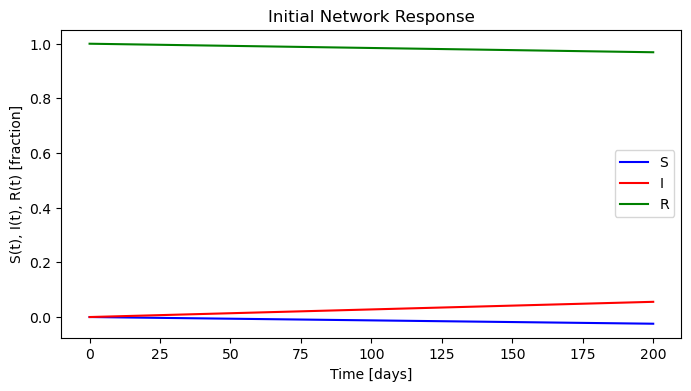

In [177]:
# Prepare t_num for network
t_num = t_num.view(-1,1).double()
t_rescaled = t_num / 1000.0
# Testing network
S, I, R = net(t_rescaled)
fig, ax = plot_solution(t_num, S, I, R, title='Initial Network Response')

In [178]:
# Testing ODE loss
t_num = t_num.clone().requires_grad_()
loss, _, _, _, _, _, _, _, _, _ = get_loss_ode(t_num, net, beta_SIR, alpha_SIR)
print(loss)

tensor(0.0642, dtype=torch.float64, grad_fn=<AddBackward0>)


In [179]:
# Testing IC loss
loss = get_loss_initial_condition(t_num[0], net, S_data[0], I_data[0], R_data[0])
print(loss)
# Testing smoothing
#plt.figure()
xlin = torch.linspace(0, 1.0, 1000)
#plt.plot(xlin, smooth_thresholding(xlin, torch.tensor(0.01), torch.tensor(50.0)))

tensor(1.9866, dtype=torch.float64, grad_fn=<AddBackward0>)


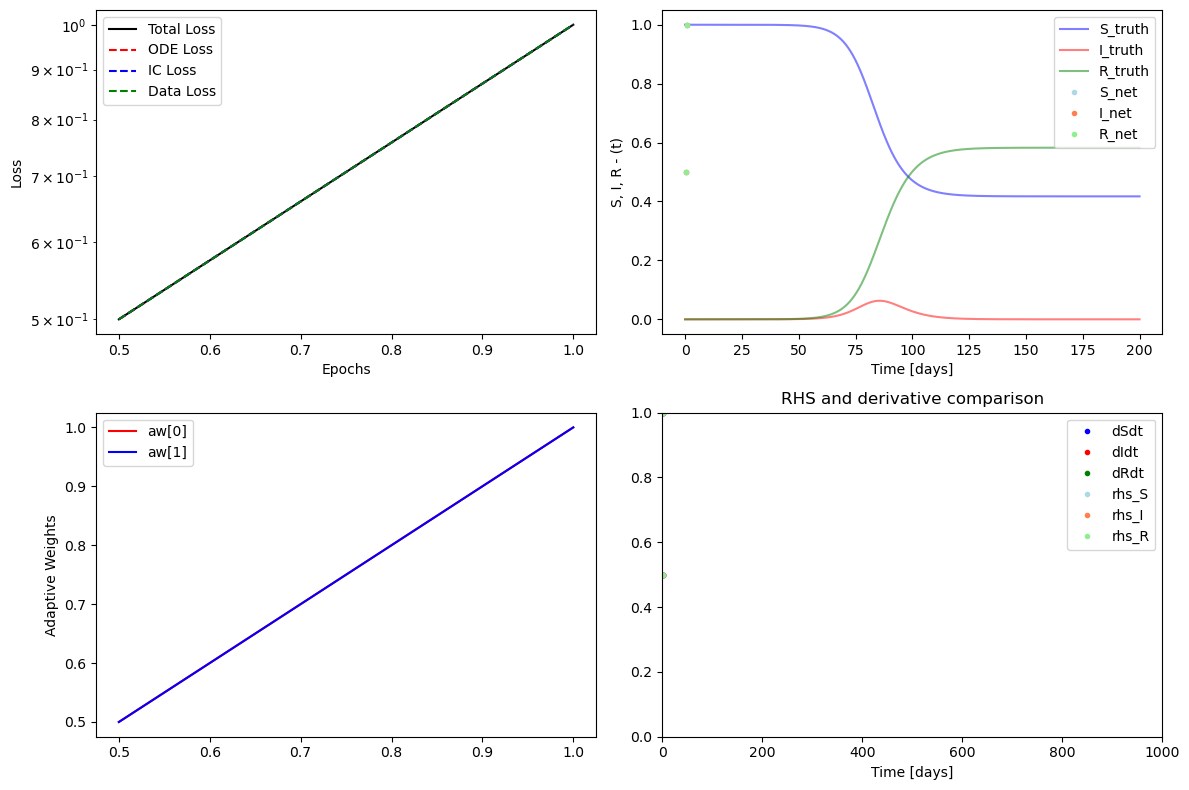

In [180]:
# SoftAdapt setup
softadapt_obj  = LossWeightedSoftAdapt(beta=0.1) # Using loss weighted soft adapt as it is the recommended one.
epochs_to_make_change = 5
adapt_weights = torch.tensor([0.25, 0.25, 0.25, 0.25])    # Initial weighting of objects.

# Setup optimizer
# If we are to estimate beta and alpha
beta_trainable = torch.tensor(beta_SIR * 3.0, device=my_device, dtype=torch.float64, requires_grad=True)
alpha_trainable = torch.tensor(alpha_SIR * 0.3, device=my_device, dtype=torch.float64, requires_grad=True)

learning_rate = 3e-4
#optimizer = optim.Adam(list(net.parameters()) + [beta_trainable, alpha_trainable], lr=learning_rate, weight_decay=1e-6)
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-6)
#optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5)

# Setup training scheduler as in the DINN paper
base_lr = 1e-5
max_lr = 1e-3   # Set your maximum learning rate
gamma_lr = 0.85
step_size_up = 1000  # Set the number of iterations for the learning rate to go from base_lr to max_lr
scheduler = optim.lr_scheduler.CyclicLR(optimizer, 
                                        base_lr=base_lr, 
                                        max_lr=max_lr, 
                                        step_size_up=step_size_up, 
                                        mode='exp_range',
                                        cycle_momentum=False)

epochs_saved = []
loss_saved = []
loss_ode_saved = []
loss_ic_saved = []
loss_data_saved = []
loss_people_count_saved = []
aw_saved = []

# Create plot
fig, ax, line_loss_total, line_loss_ode, line_loss_ic, line_loss_data, line_S, line_I, line_R, line_RHS_S, line_RHS_I, line_RHS_R, line_dSdt, line_dIdt, line_dRdt, line_aw0, line_aw1 = monitor_plot()

In [181]:
time_total = []
time_ode = []
time_ic = []
time_data = []
time_pc = []
time_backward = []
time_save = []
epoch_start = 0

# Move to device
t_num_cuda = t_data_points.clone().to(my_device).type(torch.float64)
S_data_cuda = S_data_points.to(my_device).type(torch.float64)
S0 = torch.tensor(S0_num, device=my_device, dtype=torch.float64)
I_data_cuda = I_data_points.to(my_device).type(torch.float64)
I0 = torch.tensor(I0_num, device=my_device, dtype=torch.float64)
R_data_cuda = R_data_points.to(my_device).type(torch.float64)
R0 = torch.tensor(R0_num, device=my_device, dtype=torch.float64)
# RAD sampling from DeepXDE
t_train_init = torch.linspace(0, n_days, 1001, device=my_device, requires_grad=True, dtype=torch.float64).unsqueeze(1)


In [195]:
num_epochs = 70000
epoch_range = range(epoch_start, num_epochs+epoch_start+1)
save_every = 100
loss1, loss2, loss3, loss4 = [], [], [], []

net = net.to(my_device)

start_total = tdt()
for epoch_idx, epoch in enumerate(epoch_range):
    time_total.append( tdt() - start_total )
    start_total = tdt()
    
    net.train()
    optimizer.zero_grad()

    # Get network response
    if epoch % 100 == 0 and epoch_idx != 0:
        # Calculate residual
        residual_S = dSdt - rhs_S
        residual_I = dIdt - rhs_I
        residual_R = dRdt - rhs_R
        residual = residual_S.abs() + residual_I.abs() + residual_R.abs()
        
        # Calculate RAD from paper "A comprehensive study of non-adaptive and residual-based adaptivesampling for physics-informed neural networks"
        k = 2
        c = 0
        expected_value = torch.mean(residual**k)
        p_x = residual**k/expected_value + c
        A = torch.sum(p_x)
        p_x_wavy = p_x / A 

        # Sample based on distribution p_x_wavy
        p = p_x_wavy.squeeze().cumsum(0)
        idx = torch.tensor([torch.searchsorted(p.to('cpu'), torch.rand(1)) for _ in range(1000)])
        temp = t_train.clone().long().squeeze()
        t_train = temp[idx].double().view(-1,1)
        
        # Plotting to prove it works
        #plt.figure()
        #plt.plot(p_x_wavy.to('cpu').detach())
        #plt.figure()
        #plt.hist(t_train.to('cpu').detach().squeeze(), bins=100, color='k', alpha=0.5)
        #break
        
    else:
        t_train = t_train_init.clone().requires_grad_()
        
    # Set t_train to 0.0->1.0 to ensure our initial weights and optimizer behaves roughly as expected.
    t_train = t_train / n_days
    t_train.requires_grad_()
    # Loss
    start = tdt()
    loss_ode, S, I, R, dSdt, dIdt, dRdt, rhs_S, rhs_I, rhs_R = get_loss_ode(t_train, net, beta_SIR, alpha_SIR)
    time_ode.append( tdt()-start )
    start = tdt()
    loss_ic = get_loss_initial_condition(t_train[0], net, S0, I0, R0)
    time_ic.append( tdt()-start )
    start = tdt()
    loss_data = get_loss_data(t_num_cuda, net, S_data_cuda, I_data_cuda, R_data_cuda)
    time_data.append( tdt()-start )
    start = tdt()
    #loss_people_count, _ = get_loss_for_not_correct_number_of_people(t_train, net)
    loss_people_count, _ = get_loss_for_not_correct_number_of_people_new(t_train, net)
    time_pc.append( tdt()-start)
    
    t_train = t_train * n_days
    
    loss1.append( loss_ode )
    loss2.append( loss_ic )
    loss3.append( loss_data )
    loss4.append( loss_people_count )
    
    # Using the softadapt package.
    if epoch % epochs_to_make_change == 0 and epoch_idx != 0:
        adapt_weights = softadapt_obj.get_component_weights(torch.tensor(loss1),
                                                            torch.tensor(loss2),
                                                            torch.tensor(loss3),
                                                            torch.tensor(loss4),
                                                            verbose=False)
        loss1, loss2, loss3, loss4 = [], [], [], []

    #loss = loss_data
    #loss = loss_data + loss_ode + loss_ic
    loss = adapt_weights[0]*loss_ode + adapt_weights[1]*loss_ic + adapt_weights[2]*loss_data + adapt_weights[3]*loss_people_count
    
    start = tdt()
    loss.backward()
    time_backward.append( tdt()-start )
    optimizer.step()
    #scheduler.step()

    if (epoch+1) % save_every == 0 or epoch == 0:
        epochs_saved.append( epoch )
        loss_saved.append( loss )
        loss_ode_saved.append( loss_ode )
        loss_ic_saved.append( loss_ic )
        loss_data_saved.append( loss_data )
        loss_people_count_saved.append( loss_people_count )
        aw_saved.append( [adapt_weights[0], adapt_weights[1], adapt_weights[2], adapt_weights[3]] )
    
    if False:  # Make plot that shows loss, solution, adaptive weights, residuals
        if (epoch+1) % save_every == 0 or epoch == 0:
            # Change plot [0]
            line_loss_total.set_data(epochs_saved, loss_saved)
            line_loss_ode.set_data(epochs_saved, loss_ode_saved)
            line_loss_ic.set_data(epochs_saved, loss_ic_saved)
            line_loss_data.set_data(epochs_saved, loss_data_saved)
            ax[0,0].set_xlim(0, max(epochs_saved) + 100)
            max_val = max([max(loss_saved), max(loss_ode_saved), max(loss_ic_saved)])
            ax[0,0].set_ylim(1e-10, max_val*2)

            line_S.set_data(t_train[::20].to('cpu').detach(), S[::20].to('cpu').detach())
            line_I.set_data(t_train[::20].to('cpu').detach(), I[::20].to('cpu').detach())
            line_R.set_data(t_train[::20].to('cpu').detach(), R[::20].to('cpu').detach())

            line_aw0.set_data(epochs_saved, np.transpose(aw_saved)[0,:])
            line_aw1.set_data(epochs_saved, np.transpose(aw_saved)[1,:])
            ax[1,0].set_xlim(0, max(epochs_saved) + 100)
            max_val = max([max(loss_saved), max(loss_ode_saved), max(loss_ic_saved)])
            ax[1,0].set_ylim(-0.1, 1.1)           
           
            line_dSdt.set_data(t_train[::1].to('cpu').detach(), dSdt[::1].to('cpu').detach())
            line_dIdt.set_data(t_train[::1].to('cpu').detach(), dIdt[::1].to('cpu').detach())
            line_dRdt.set_data(t_train[::1].to('cpu').detach(), dRdt[::1].to('cpu').detach())
            line_RHS_S.set_data(t_train[::1].to('cpu').detach(), rhs_S[::1].to('cpu').detach())
            line_RHS_I.set_data(t_train[::1].to('cpu').detach(), rhs_I[::1].to('cpu').detach())
            line_RHS_R.set_data(t_train[::1].to('cpu').detach(), rhs_R[::1].to('cpu').detach())
            min_val = min(min(rhs_S), min(rhs_I), min(rhs_R), min(dSdt), min(dIdt), min(dRdt))
            max_val = max(max(rhs_S), max(rhs_I), max(rhs_R), max(dSdt), max(dIdt), max(dRdt))
            ax[1,1].set_ylim(min_val.to('cpu').detach(), max_val.to('cpu').detach())
            
            display(fig)
            clear_output(wait = True)
    else:
        if (epoch+1) % save_every == 0 or epoch == 0:
            print(f"Epoch {epoch+1:5}, Loss: {loss.item():10.5E}, ode_loss: {loss_ode:10.5E}, ic_loss: {loss_ic:10.5E}"
                  f", data_loss: {loss_data:10.5E}, count_loss: {loss_people_count:10.5E}"
                  f"\n             aw[0]: {adapt_weights[0]:3.6f}, aw[1]: {adapt_weights[1]:3.6f},"
                  f" aw[2]: {adapt_weights[2]:3.6f}, aw[3]: {adapt_weights[3]:3.6f},")
            
epoch_start += epoch

Epoch   200, Loss: 3.19003E-05, ode_loss: 2.52038E-05, ic_loss: 1.60662E-08, data_loss: 3.79594E-05, count_loss: 2.29265E-06
             aw[0]: 0.385034, aw[1]: 0.000235, aw[2]: 0.582810, aw[3]: 0.031767,
Epoch   300, Loss: 3.13319E-05, ode_loss: 2.49662E-05, ic_loss: 1.32908E-08, data_loss: 3.78546E-05, count_loss: 1.59673E-06
             aw[0]: 0.382735, aw[1]: 0.000243, aw[2]: 0.573434, aw[3]: 0.043437,
Epoch   400, Loss: 3.11073E-05, ode_loss: 2.48591E-05, ic_loss: 1.18950E-08, data_loss: 3.75863E-05, count_loss: 1.53986E-06
             aw[0]: 0.383333, aw[1]: 0.000226, aw[2]: 0.572288, aw[3]: 0.044001,
Epoch   500, Loss: 3.08349E-05, ode_loss: 2.47628E-05, ic_loss: 1.04498E-08, data_loss: 3.73476E-05, count_loss: 1.40071E-06
             aw[0]: 0.383720, aw[1]: 0.000215, aw[2]: 0.569457, aw[3]: 0.046455,
Epoch   600, Loss: 3.06386E-05, ode_loss: 2.47057E-05, ic_loss: 9.61335E-09, data_loss: 3.70226E-05, count_loss: 1.42623E-06
             aw[0]: 0.385238, aw[1]: 0.000198, aw[2

Epoch  4200, Loss: 2.58207E-05, ode_loss: 2.37721E-05, ic_loss: 1.05527E-10, data_loss: 2.85905E-05, count_loss: 2.27726E-06
             aw[0]: 0.433222, aw[1]: 0.000005, aw[2]: 0.540864, aw[3]: 0.025723,
Epoch  4300, Loss: 2.57312E-05, ode_loss: 2.37433E-05, ic_loss: 9.62911E-11, data_loss: 2.84597E-05, count_loss: 2.25061E-06
             aw[0]: 0.434064, aw[1]: 0.000005, aw[2]: 0.539960, aw[3]: 0.025784,
Epoch  4400, Loss: 2.56494E-05, ode_loss: 2.37263E-05, ic_loss: 8.96963E-11, data_loss: 2.83271E-05, count_loss: 2.23351E-06
             aw[0]: 0.434912, aw[1]: 0.000005, aw[2]: 0.539171, aw[3]: 0.025724,
Epoch  4500, Loss: 2.55583E-05, ode_loss: 2.36863E-05, ic_loss: 8.90929E-11, data_loss: 2.82080E-05, count_loss: 2.19832E-06
             aw[0]: 0.435855, aw[1]: 0.000006, aw[2]: 0.538061, aw[3]: 0.025890,
Epoch  4600, Loss: 2.54771E-05, ode_loss: 2.36631E-05, ic_loss: 8.88963E-11, data_loss: 2.80810E-05, count_loss: 2.18211E-06
             aw[0]: 0.436894, aw[1]: 0.000006, aw[2

Epoch  8200, Loss: 2.38855E-05, ode_loss: 2.29722E-05, ic_loss: 2.02177E-09, data_loss: 2.58164E-05, count_loss: 1.48700E-06
             aw[0]: 0.455866, aw[1]: 0.000060, aw[2]: 0.518077, aw[3]: 0.025798,
Epoch  8300, Loss: 2.38612E-05, ode_loss: 2.29804E-05, ic_loss: 2.12575E-09, data_loss: 2.57644E-05, count_loss: 1.48020E-06
             aw[0]: 0.456577, aw[1]: 0.000061, aw[2]: 0.517409, aw[3]: 0.025753,
Epoch  8400, Loss: 2.38508E-05, ode_loss: 2.29499E-05, ic_loss: 2.19217E-09, data_loss: 2.57584E-05, count_loss: 1.46677E-06
             aw[0]: 0.456483, aw[1]: 0.000063, aw[2]: 0.517779, aw[3]: 0.025474,
Epoch  8500, Loss: 2.38283E-05, ode_loss: 2.29423E-05, ic_loss: 2.29748E-09, data_loss: 2.57256E-05, count_loss: 1.45403E-06
             aw[0]: 0.456856, aw[1]: 0.000065, aw[2]: 0.517377, aw[3]: 0.025502,
Epoch  8600, Loss: 2.38072E-05, ode_loss: 2.29270E-05, ic_loss: 2.39765E-09, data_loss: 2.57052E-05, count_loss: 1.43281E-06
             aw[0]: 0.457182, aw[1]: 0.000066, aw[2

Epoch 12200, Loss: 2.33970E-05, ode_loss: 2.25832E-05, ic_loss: 5.14661E-09, data_loss: 2.51760E-05, count_loss: 1.06132E-06
             aw[0]: 0.464348, aw[1]: 0.000097, aw[2]: 0.511820, aw[3]: 0.023531,
Epoch 12300, Loss: 2.33911E-05, ode_loss: 2.25737E-05, ic_loss: 5.16448E-09, data_loss: 2.51689E-05, count_loss: 1.05710E-06
             aw[0]: 0.464340, aw[1]: 0.000097, aw[2]: 0.511919, aw[3]: 0.023439,
Epoch 12400, Loss: 2.33845E-05, ode_loss: 2.25629E-05, ic_loss: 5.21855E-09, data_loss: 2.51650E-05, count_loss: 1.04635E-06
             aw[0]: 0.464479, aw[1]: 0.000097, aw[2]: 0.511826, aw[3]: 0.023394,
Epoch 12500, Loss: 2.33798E-05, ode_loss: 2.25543E-05, ic_loss: 5.22516E-09, data_loss: 2.51561E-05, count_loss: 1.04475E-06
             aw[0]: 0.464445, aw[1]: 0.000097, aw[2]: 0.512013, aw[3]: 0.023240,
Epoch 12600, Loss: 2.33807E-05, ode_loss: 2.25237E-05, ic_loss: 5.25165E-09, data_loss: 2.51730E-05, count_loss: 1.03341E-06
             aw[0]: 0.464058, aw[1]: 0.000098, aw[2

Epoch 16200, Loss: 2.32051E-05, ode_loss: 2.23537E-05, ic_loss: 6.67593E-09, data_loss: 2.48622E-05, count_loss: 8.82071E-07
             aw[0]: 0.468490, aw[1]: 0.000100, aw[2]: 0.511424, aw[3]: 0.019779,
Epoch 16300, Loss: 2.32048E-05, ode_loss: 2.23366E-05, ic_loss: 6.68815E-09, data_loss: 2.48674E-05, count_loss: 8.80014E-07
             aw[0]: 0.468241, aw[1]: 0.000100, aw[2]: 0.511860, aw[3]: 0.019592,
Epoch 16400, Loss: 2.32009E-05, ode_loss: 2.23325E-05, ic_loss: 6.73680E-09, data_loss: 2.48626E-05, count_loss: 8.70792E-07
             aw[0]: 0.468494, aw[1]: 0.000100, aw[2]: 0.511661, aw[3]: 0.019538,
Epoch 16500, Loss: 2.31973E-05, ode_loss: 2.23267E-05, ic_loss: 6.69085E-09, data_loss: 2.48553E-05, count_loss: 8.72669E-07
             aw[0]: 0.468412, aw[1]: 0.000100, aw[2]: 0.511852, aw[3]: 0.019429,
Epoch 16600, Loss: 2.31920E-05, ode_loss: 2.23254E-05, ic_loss: 6.62534E-09, data_loss: 2.48412E-05, count_loss: 8.80687E-07
             aw[0]: 0.468420, aw[1]: 0.000100, aw[2

Epoch 20200, Loss: 2.30816E-05, ode_loss: 2.21969E-05, ic_loss: 6.99849E-09, data_loss: 2.45849E-05, count_loss: 8.44375E-07
             aw[0]: 0.470533, aw[1]: 0.000102, aw[2]: 0.513483, aw[3]: 0.015672,
Epoch 20300, Loss: 2.30785E-05, ode_loss: 2.21960E-05, ic_loss: 6.96887E-09, data_loss: 2.45760E-05, count_loss: 8.42324E-07
             aw[0]: 0.470576, aw[1]: 0.000102, aw[2]: 0.513526, aw[3]: 0.015585,
Epoch 20400, Loss: 2.30716E-05, ode_loss: 2.22041E-05, ic_loss: 6.90619E-09, data_loss: 2.45555E-05, count_loss: 8.45931E-07
             aw[0]: 0.470790, aw[1]: 0.000102, aw[2]: 0.513322, aw[3]: 0.015575,
Epoch 20500, Loss: 2.30693E-05, ode_loss: 2.22039E-05, ic_loss: 6.94586E-09, data_loss: 2.45467E-05, count_loss: 8.45785E-07
             aw[0]: 0.470956, aw[1]: 0.000102, aw[2]: 0.513274, aw[3]: 0.015457,
Epoch 20600, Loss: 2.30745E-05, ode_loss: 2.21738E-05, ic_loss: 6.94551E-09, data_loss: 2.45697E-05, count_loss: 8.50187E-07
             aw[0]: 0.470264, aw[1]: 0.000102, aw[2

Epoch 24200, Loss: 2.29895E-05, ode_loss: 2.21357E-05, ic_loss: 6.82600E-09, data_loss: 2.43031E-05, count_loss: 8.58867E-07
             aw[0]: 0.471832, aw[1]: 0.000110, aw[2]: 0.515771, aw[3]: 0.012075,
Epoch 24300, Loss: 2.29824E-05, ode_loss: 2.21406E-05, ic_loss: 6.79783E-09, data_loss: 2.42881E-05, count_loss: 8.53388E-07
             aw[0]: 0.471963, aw[1]: 0.000110, aw[2]: 0.515582, aw[3]: 0.012132,
Epoch 24400, Loss: 2.29817E-05, ode_loss: 2.21368E-05, ic_loss: 6.82226E-09, data_loss: 2.42856E-05, count_loss: 8.56761E-07
             aw[0]: 0.471925, aw[1]: 0.000110, aw[2]: 0.515715, aw[3]: 0.012037,
Epoch 24500, Loss: 2.29839E-05, ode_loss: 2.21309E-05, ic_loss: 6.84453E-09, data_loss: 2.42858E-05, count_loss: 8.60516E-07
             aw[0]: 0.471833, aw[1]: 0.000111, aw[2]: 0.516005, aw[3]: 0.011838,
Epoch 24600, Loss: 2.29838E-05, ode_loss: 2.21282E-05, ic_loss: 6.84795E-09, data_loss: 2.42830E-05, count_loss: 8.55910E-07
             aw[0]: 0.471801, aw[1]: 0.000111, aw[2

Epoch 28200, Loss: 2.29001E-05, ode_loss: 2.20519E-05, ic_loss: 6.57198E-09, data_loss: 2.41057E-05, count_loss: 7.84239E-07
             aw[0]: 0.471073, aw[1]: 0.000122, aw[2]: 0.518726, aw[3]: 0.009865,
Epoch 28300, Loss: 2.28996E-05, ode_loss: 2.20427E-05, ic_loss: 6.58403E-09, data_loss: 2.41090E-05, count_loss: 7.84815E-07
             aw[0]: 0.470851, aw[1]: 0.000122, aw[2]: 0.519021, aw[3]: 0.009792,
Epoch 28400, Loss: 2.28983E-05, ode_loss: 2.20399E-05, ic_loss: 6.59274E-09, data_loss: 2.41060E-05, count_loss: 7.82059E-07
             aw[0]: 0.470803, aw[1]: 0.000123, aw[2]: 0.519132, aw[3]: 0.009727,
Epoch 28500, Loss: 2.28911E-05, ode_loss: 2.20389E-05, ic_loss: 6.57079E-09, data_loss: 2.40971E-05, count_loss: 7.71839E-07
             aw[0]: 0.470848, aw[1]: 0.000123, aw[2]: 0.519008, aw[3]: 0.009806,
Epoch 28600, Loss: 2.28915E-05, ode_loss: 2.20279E-05, ic_loss: 6.57218E-09, data_loss: 2.41033E-05, count_loss: 7.73018E-07
             aw[0]: 0.470550, aw[1]: 0.000124, aw[2

Epoch 32200, Loss: 2.28276E-05, ode_loss: 2.19170E-05, ic_loss: 6.29841E-09, data_loss: 2.40069E-05, count_loss: 6.19502E-07
             aw[0]: 0.469623, aw[1]: 0.000133, aw[2]: 0.521928, aw[3]: 0.008100,
Epoch 32300, Loss: 2.28220E-05, ode_loss: 2.19184E-05, ic_loss: 6.29987E-09, data_loss: 2.39963E-05, count_loss: 6.12139E-07
             aw[0]: 0.469836, aw[1]: 0.000133, aw[2]: 0.521703, aw[3]: 0.008112,
Epoch 32400, Loss: 2.28253E-05, ode_loss: 2.18974E-05, ic_loss: 6.33352E-09, data_loss: 2.40155E-05, count_loss: 6.10721E-07
             aw[0]: 0.469349, aw[1]: 0.000133, aw[2]: 0.522281, aw[3]: 0.008021,
Epoch 32500, Loss: 2.28252E-05, ode_loss: 2.18887E-05, ic_loss: 6.32919E-09, data_loss: 2.40203E-05, count_loss: 6.05620E-07
             aw[0]: 0.469191, aw[1]: 0.000134, aw[2]: 0.522493, aw[3]: 0.007967,
Epoch 32600, Loss: 2.28165E-05, ode_loss: 2.18987E-05, ic_loss: 6.25949E-09, data_loss: 2.40008E-05, count_loss: 5.95385E-07
             aw[0]: 0.469481, aw[1]: 0.000133, aw[2

Epoch 36200, Loss: 2.27708E-05, ode_loss: 2.17848E-05, ic_loss: 6.20293E-09, data_loss: 2.39396E-05, count_loss: 3.89436E-07
             aw[0]: 0.473330, aw[1]: 0.000129, aw[2]: 0.520356, aw[3]: 0.005967,
Epoch 36300, Loss: 2.27712E-05, ode_loss: 2.17794E-05, ic_loss: 6.20238E-09, data_loss: 2.39423E-05, count_loss: 3.86875E-07
             aw[0]: 0.473287, aw[1]: 0.000130, aw[2]: 0.520459, aw[3]: 0.005907,
Epoch 36400, Loss: 2.27684E-05, ode_loss: 2.17854E-05, ic_loss: 6.20173E-09, data_loss: 2.39305E-05, count_loss: 3.85462E-07
             aw[0]: 0.473470, aw[1]: 0.000130, aw[2]: 0.520316, aw[3]: 0.005867,
Epoch 36500, Loss: 2.27677E-05, ode_loss: 2.17832E-05, ic_loss: 6.19566E-09, data_loss: 2.39295E-05, count_loss: 3.81367E-07
             aw[0]: 0.473516, aw[1]: 0.000130, aw[2]: 0.520311, aw[3]: 0.005825,
Epoch 36600, Loss: 2.27683E-05, ode_loss: 2.17723E-05, ic_loss: 6.12421E-09, data_loss: 2.39394E-05, count_loss: 3.76754E-07
             aw[0]: 0.473256, aw[1]: 0.000130, aw[2

Epoch 40200, Loss: 2.27210E-05, ode_loss: 2.17375E-05, ic_loss: 5.92650E-09, data_loss: 2.38756E-05, count_loss: 2.40797E-07
             aw[0]: 0.473730, aw[1]: 0.000141, aw[2]: 0.520280, aw[3]: 0.005632,
Epoch 40300, Loss: 2.27205E-05, ode_loss: 2.17307E-05, ic_loss: 5.86023E-09, data_loss: 2.38794E-05, count_loss: 2.39059E-07
             aw[0]: 0.473564, aw[1]: 0.000140, aw[2]: 0.520460, aw[3]: 0.005617,
Epoch 40400, Loss: 2.27155E-05, ode_loss: 2.17448E-05, ic_loss: 5.84981E-09, data_loss: 2.38589E-05, count_loss: 2.36065E-07
             aw[0]: 0.474005, aw[1]: 0.000141, aw[2]: 0.520016, aw[3]: 0.005619,
Epoch 40500, Loss: 2.27157E-05, ode_loss: 2.17428E-05, ic_loss: 5.78043E-09, data_loss: 2.38595E-05, count_loss: 2.34880E-07
             aw[0]: 0.473910, aw[1]: 0.000142, aw[2]: 0.520139, aw[3]: 0.005591,
Epoch 40600, Loss: 2.27144E-05, ode_loss: 2.17384E-05, ic_loss: 5.67906E-09, data_loss: 2.38659E-05, count_loss: 2.26433E-07
             aw[0]: 0.473738, aw[1]: 0.000144, aw[2

Epoch 44200, Loss: 2.26841E-05, ode_loss: 2.16997E-05, ic_loss: 5.57051E-09, data_loss: 2.38253E-05, count_loss: 1.48829E-07
             aw[0]: 0.473867, aw[1]: 0.000151, aw[2]: 0.520477, aw[3]: 0.005287,
Epoch 44300, Loss: 2.26824E-05, ode_loss: 2.17012E-05, ic_loss: 5.55864E-09, data_loss: 2.38192E-05, count_loss: 1.50320E-07
             aw[0]: 0.473991, aw[1]: 0.000150, aw[2]: 0.520399, aw[3]: 0.005242,
Epoch 44400, Loss: 2.26803E-05, ode_loss: 2.17083E-05, ic_loss: 5.56547E-09, data_loss: 2.38076E-05, count_loss: 1.49933E-07
             aw[0]: 0.474276, aw[1]: 0.000150, aw[2]: 0.520162, aw[3]: 0.005194,
Epoch 44500, Loss: 2.26816E-05, ode_loss: 2.17000E-05, ic_loss: 5.55354E-09, data_loss: 2.38156E-05, count_loss: 1.47710E-07
             aw[0]: 0.474090, aw[1]: 0.000149, aw[2]: 0.520376, aw[3]: 0.005166,
Epoch 44600, Loss: 2.26814E-05, ode_loss: 2.16971E-05, ic_loss: 5.56491E-09, data_loss: 2.38188E-05, count_loss: 1.44309E-07
             aw[0]: 0.474036, aw[1]: 0.000150, aw[2

Epoch 48200, Loss: 2.26660E-05, ode_loss: 2.16276E-05, ic_loss: 5.70729E-09, data_loss: 2.38145E-05, count_loss: 9.62629E-08
             aw[0]: 0.474385, aw[1]: 0.000148, aw[2]: 0.520931, aw[3]: 0.004317,
Epoch 48300, Loss: 2.26629E-05, ode_loss: 2.16327E-05, ic_loss: 5.69944E-09, data_loss: 2.38009E-05, count_loss: 9.94661E-08
             aw[0]: 0.474632, aw[1]: 0.000146, aw[2]: 0.520773, aw[3]: 0.004230,
Epoch 48400, Loss: 2.26616E-05, ode_loss: 2.16376E-05, ic_loss: 5.70534E-09, data_loss: 2.37941E-05, count_loss: 9.77565E-08
             aw[0]: 0.474843, aw[1]: 0.000147, aw[2]: 0.520581, aw[3]: 0.004210,
Epoch 48500, Loss: 2.26618E-05, ode_loss: 2.16346E-05, ic_loss: 5.72359E-09, data_loss: 2.37978E-05, count_loss: 9.46169E-08
             aw[0]: 0.474752, aw[1]: 0.000148, aw[2]: 0.520651, aw[3]: 0.004230,
Epoch 48600, Loss: 2.26603E-05, ode_loss: 2.16405E-05, ic_loss: 5.73124E-09, data_loss: 2.37891E-05, count_loss: 9.47908E-08
             aw[0]: 0.474959, aw[1]: 0.000148, aw[2

Epoch 52200, Loss: 2.26501E-05, ode_loss: 2.15814E-05, ic_loss: 5.77225E-09, data_loss: 2.37781E-05, count_loss: 6.74716E-08
             aw[0]: 0.475511, aw[1]: 0.000141, aw[2]: 0.520970, aw[3]: 0.003159,
Epoch 52300, Loss: 2.26517E-05, ode_loss: 2.15733E-05, ic_loss: 5.78950E-09, data_loss: 2.37883E-05, count_loss: 6.48144E-08
             aw[0]: 0.475264, aw[1]: 0.000142, aw[2]: 0.521199, aw[3]: 0.003175,
Epoch 52400, Loss: 2.26504E-05, ode_loss: 2.15723E-05, ic_loss: 5.78068E-09, data_loss: 2.37839E-05, count_loss: 6.59350E-08
             aw[0]: 0.475311, aw[1]: 0.000141, aw[2]: 0.521218, aw[3]: 0.003110,
Epoch 52500, Loss: 2.26492E-05, ode_loss: 2.15743E-05, ic_loss: 5.79212E-09, data_loss: 2.37801E-05, count_loss: 6.45691E-08
             aw[0]: 0.475454, aw[1]: 0.000141, aw[2]: 0.521082, aw[3]: 0.003104,
Epoch 52600, Loss: 2.26494E-05, ode_loss: 2.15737E-05, ic_loss: 5.81183E-09, data_loss: 2.37811E-05, count_loss: 6.27668E-08
             aw[0]: 0.475390, aw[1]: 0.000142, aw[2

Epoch 56200, Loss: 2.26364E-05, ode_loss: 2.15561E-05, ic_loss: 5.83258E-09, data_loss: 2.37318E-05, count_loss: 4.51938E-08
             aw[0]: 0.475987, aw[1]: 0.000137, aw[2]: 0.521488, aw[3]: 0.002168,
Epoch 56300, Loss: 2.26367E-05, ode_loss: 2.15525E-05, ic_loss: 5.85349E-09, data_loss: 2.37355E-05, count_loss: 4.37382E-08
             aw[0]: 0.475969, aw[1]: 0.000137, aw[2]: 0.521511, aw[3]: 0.002162,
Epoch 56400, Loss: 2.26301E-05, ode_loss: 2.15702E-05, ic_loss: 5.84843E-09, data_loss: 2.37059E-05, count_loss: 4.58481E-08
             aw[0]: 0.476620, aw[1]: 0.000136, aw[2]: 0.520936, aw[3]: 0.002087,
Epoch 56500, Loss: 2.26337E-05, ode_loss: 2.15509E-05, ic_loss: 5.85789E-09, data_loss: 2.37294E-05, count_loss: 4.29000E-08
             aw[0]: 0.476173, aw[1]: 0.000137, aw[2]: 0.521363, aw[3]: 0.002106,
Epoch 56600, Loss: 2.26328E-05, ode_loss: 2.15568E-05, ic_loss: 5.88359E-09, data_loss: 2.37215E-05, count_loss: 4.28837E-08
             aw[0]: 0.476294, aw[1]: 0.000138, aw[2

Epoch 60200, Loss: 2.26277E-05, ode_loss: 2.15082E-05, ic_loss: 5.81906E-09, data_loss: 2.37159E-05, count_loss: 2.88603E-08
             aw[0]: 0.475410, aw[1]: 0.000133, aw[2]: 0.522958, aw[3]: 0.001278,
Epoch 60300, Loss: 2.26246E-05, ode_loss: 2.15226E-05, ic_loss: 5.81743E-09, data_loss: 2.36965E-05, count_loss: 2.95977E-08
             aw[0]: 0.475726, aw[1]: 0.000134, aw[2]: 0.522679, aw[3]: 0.001241,
Epoch 60400, Loss: 2.26233E-05, ode_loss: 2.15280E-05, ic_loss: 5.81874E-09, data_loss: 2.36889E-05, count_loss: 2.91685E-08
             aw[0]: 0.475840, aw[1]: 0.000134, aw[2]: 0.522579, aw[3]: 0.001226,
Epoch 60500, Loss: 2.26267E-05, ode_loss: 2.15210E-05, ic_loss: 5.80808E-09, data_loss: 2.37003E-05, count_loss: 2.82299E-08
             aw[0]: 0.475517, aw[1]: 0.000134, aw[2]: 0.522910, aw[3]: 0.001218,
Epoch 60600, Loss: 2.26247E-05, ode_loss: 2.15260E-05, ic_loss: 5.77901E-09, data_loss: 2.36910E-05, count_loss: 2.87999E-08
             aw[0]: 0.475646, aw[1]: 0.000134, aw[2

Epoch 64200, Loss: 2.26067E-05, ode_loss: 2.15122E-05, ic_loss: 5.64647E-09, data_loss: 2.36406E-05, count_loss: 1.96648E-08
             aw[0]: 0.475385, aw[1]: 0.000131, aw[2]: 0.523679, aw[3]: 0.000584,
Epoch 64300, Loss: 2.26051E-05, ode_loss: 2.15092E-05, ic_loss: 5.65378E-09, data_loss: 2.36398E-05, count_loss: 1.95297E-08
             aw[0]: 0.475428, aw[1]: 0.000130, aw[2]: 0.523650, aw[3]: 0.000571,
Epoch 64400, Loss: 2.26053E-05, ode_loss: 2.15056E-05, ic_loss: 5.67715E-09, data_loss: 2.36426E-05, count_loss: 1.92338E-08
             aw[0]: 0.475370, aw[1]: 0.000130, aw[2]: 0.523722, aw[3]: 0.000557,
Epoch 64500, Loss: 2.26040E-05, ode_loss: 2.14984E-05, ic_loss: 5.68236E-09, data_loss: 2.36461E-05, count_loss: 1.89212E-08
             aw[0]: 0.475338, aw[1]: 0.000129, aw[2]: 0.523763, aw[3]: 0.000549,
Epoch 64600, Loss: 2.26029E-05, ode_loss: 2.15101E-05, ic_loss: 5.71514E-09, data_loss: 2.36333E-05, count_loss: 1.90963E-08
             aw[0]: 0.475518, aw[1]: 0.000130, aw[2

Epoch 68200, Loss: 2.25999E-05, ode_loss: 2.14696E-05, ic_loss: 5.35449E-09, data_loss: 2.36406E-05, count_loss: 1.19282E-08
             aw[0]: 0.473473, aw[1]: 0.000129, aw[2]: 0.525984, aw[3]: 0.000193,
Epoch 68300, Loss: 2.25918E-05, ode_loss: 2.14696E-05, ic_loss: 5.35265E-09, data_loss: 2.36272E-05, count_loss: 1.22095E-08
             aw[0]: 0.473931, aw[1]: 0.000126, aw[2]: 0.525527, aw[3]: 0.000194,
Epoch 68400, Loss: 2.25890E-05, ode_loss: 2.14804E-05, ic_loss: 5.42712E-09, data_loss: 2.36129E-05, count_loss: 1.22061E-08
             aw[0]: 0.474222, aw[1]: 0.000127, aw[2]: 0.525244, aw[3]: 0.000186,
Epoch 68500, Loss: 2.25849E-05, ode_loss: 2.14866E-05, ic_loss: 5.44986E-09, data_loss: 2.36005E-05, count_loss: 1.21072E-08
             aw[0]: 0.474515, aw[1]: 0.000127, aw[2]: 0.524952, aw[3]: 0.000184,
Epoch 68600, Loss: 2.25873E-05, ode_loss: 2.14749E-05, ic_loss: 5.46796E-09, data_loss: 2.36144E-05, count_loss: 1.14232E-08
             aw[0]: 0.474211, aw[1]: 0.000127, aw[2

In [196]:
loss_saved = [ls.to('cpu').detach() for ls in loss_saved]
loss_ode_saved = [los.to('cpu').detach() for los in loss_ode_saved]
loss_ic_saved = [lis.to('cpu').detach() for lis in loss_ic_saved]
loss_data_saved = [lds.to('cpu').detach() for lds in loss_data_saved]
loss_people_count_saved = [lpc.to('cpu').detach() for lpc in loss_people_count_saved]
aw_saved = [[aw[0].to('cpu').detach(), aw[1].to('cpu').detach(), aw[2].to('cpu').detach(), aw[3].to('cpu').detach()] for aw in aw_saved]

(0.0, 0.03)

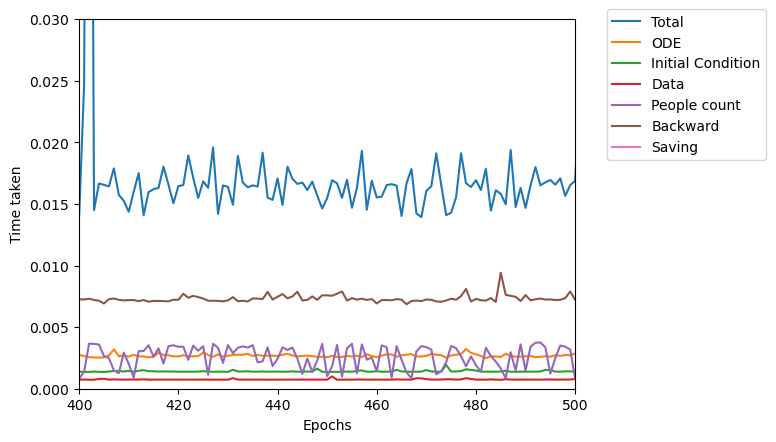

In [197]:
fig, ax = plt.subplots(1,1)
ax.plot(time_total, label='Total')
ax.plot(time_ode, label='ODE')
ax.plot(time_ic, label='Initial Condition')
ax.plot(time_data, label='Data')
ax.plot(time_pc, label='People count')
ax.plot(time_backward, label='Backward')
ax.plot(time_save, label='Saving')
ax.legend(bbox_to_anchor=(1.05, 0.6))
ax.set_ylabel('Time taken')
ax.set_xlabel('Epochs')
ax.set_xlim(400,500)
ax.set_ylim(0,0.03)

In [185]:
print(f'Beta found in network  {beta_trainable:6.5f} vs real beta  {beta_SIR:6.5f}')
print(f'alpha found in network {alpha_trainable:6.5f} vs real alpha {alpha_SIR:6.5f}')


Beta found in network  1.50000 vs real beta  0.50000
alpha found in network 0.10000 vs real alpha 0.33333


Text(0, 0.5, 'R(t)')

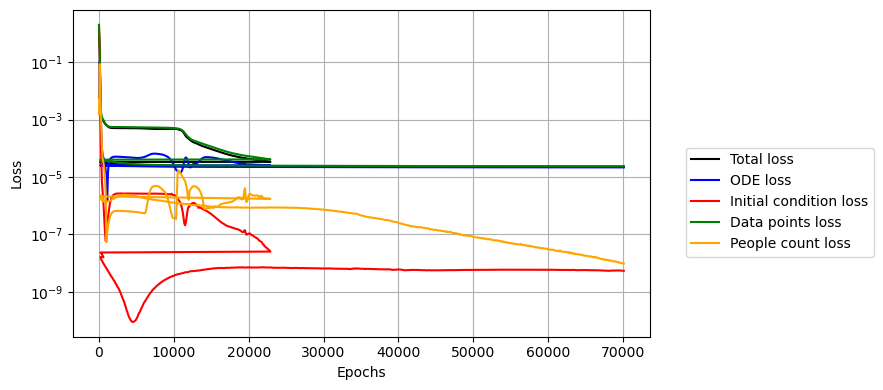

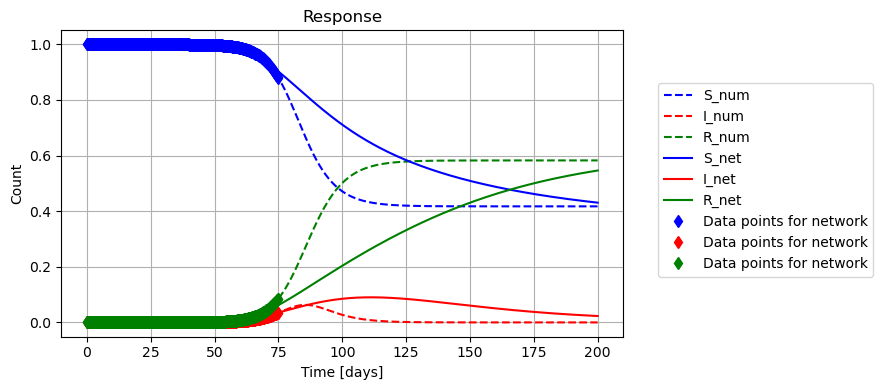

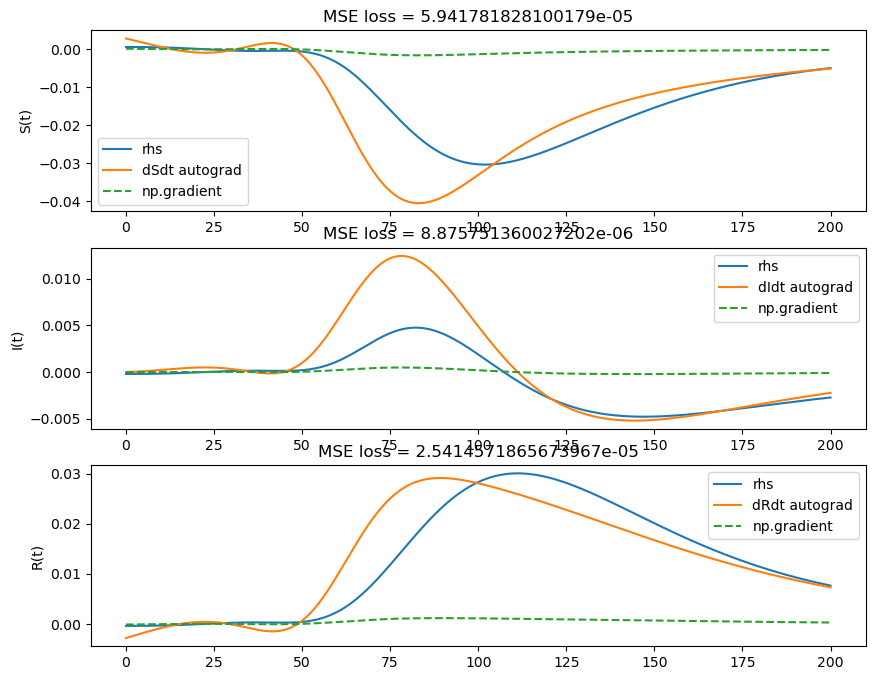

In [198]:
# Plot loss
fig, ax = plt.subplots(1, 1, figsize=(9,4))
ax.plot(epochs_saved[0:], loss_saved, color='k', label='Total loss')
ax.plot(epochs_saved[0:], loss_ode_saved, color='blue', label='ODE loss')
ax.plot(epochs_saved[0:], loss_ic_saved, color='red', label='Initial condition loss')
ax.plot(epochs_saved[0:], loss_data_saved, color='green', label='Data points loss')
ax.plot(epochs_saved[0:], loss_people_count_saved, color='orange', label='People count loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 0.6))
fig.tight_layout()

# Prepare t_num for network
net_cpu = net.to('cpu').eval()
t_num = t_num.view(-1,1).double() / 1000.0
# How the fuck does this give a low loss
loss_ode, S, I, R, dSdt, dIdt, dRdt, rhs_S, rhs_I, rhs_R = get_loss_ode(t_num.requires_grad_(), net, beta_SIR, alpha_SIR)
t_num = t_num * 1000.0

fig, ax = plt.subplots(1, 1, figsize=(9,4))
ax.plot(t_num.to('cpu').detach(), S_data.to('cpu').detach(), color='blue', linestyle='--', label='S_num')
ax.plot(t_num.to('cpu').detach(), I_data.to('cpu').detach(), color='red', linestyle='--', label='I_num')
ax.plot(t_num.to('cpu').detach(), R_data.to('cpu').detach(), color='green', linestyle='--', label='R_num')
ax.plot(t_num.to('cpu').detach(), S.to('cpu').detach(), color='blue', label='S_net')
ax.plot(t_num.to('cpu').detach(), I.to('cpu').detach(), color='red', label='I_net')
ax.plot(t_num.to('cpu').detach(), R.to('cpu').detach(), color='green', label='R_net')
ax.plot(t_data_points, S_data_points, linestyle='', marker='d', color='blue', label='Data points for network')
ax.plot(t_data_points, I_data_points, linestyle='', marker='d', color='red', label='Data points for network')
ax.plot(t_data_points, R_data_points, linestyle='', marker='d', color='green', label='Data points for network')
ax.set_xlabel('Time [days]')
ax.set_ylabel('Count')
ax.set_title('Response')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 0.85))
fig.tight_layout()

#    dSdt = -beta_SIR * S * I
#    dIdt = beta_SIR * S * I - alpha_SIR * I
#    dRdt = alpha_SIR * I

fig, ax = plt.subplots(3, 1, figsize=(10,8))
ax[0].plot(t_num.detach(), -beta_SIR * S.detach() * I.detach())
ax[0].plot(t_num.detach(), dSdt.detach())
ax[0].plot(t_num.detach(), np.gradient(S.detach().numpy().reshape(-1), 1), linestyle='--')
ax[0].legend(['rhs', 'dSdt autograd', 'np.gradient'])
ax[0].set_title(f'MSE loss = {torch_MSE_loss(-beta_SIR * S.detach() * I.detach(), dSdt.detach())}')
ax[0].set_ylabel('S(t)')
ax[1].plot(t_num.detach(), beta_SIR * S.detach() * I.detach() - alpha_SIR * I.detach())
ax[1].plot(t_num.detach(), dIdt.detach())
ax[1].plot(t_num.detach(), np.gradient(I.detach().numpy().reshape(-1), 1), linestyle='--')
ax[1].legend(['rhs', 'dIdt autograd', 'np.gradient'])
ax[1].set_title(f'MSE loss = {torch_MSE_loss(beta_SIR * S.detach() * I.detach() - alpha_SIR * I.detach(), dIdt.detach())}')
ax[1].set_ylabel('I(t)')
ax[2].plot(t_num.detach(), alpha_SIR * I.detach())
ax[2].plot(t_num.detach(), dRdt.detach())
ax[2].plot(t_num.detach(), np.gradient(R.detach().numpy().reshape(-1), 1), linestyle='--')
ax[2].legend(['rhs', 'dRdt autograd', 'np.gradient'])
ax[2].set_title(f'MSE loss = {torch_MSE_loss(alpha_SIR * I.detach(), dRdt.detach())}')
ax[2].set_ylabel('R(t)')

Text(0.5, 0, 'Time [days]')

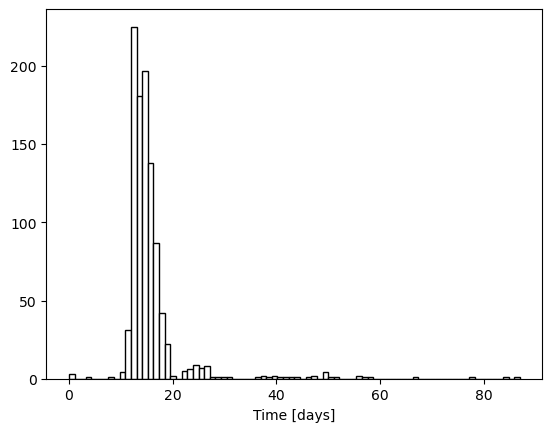

In [199]:
fig, ax = plt.subplots(1, 1)
ax.hist(t_train.to('cpu').detach().flatten(), bins=80, color='white', edgecolor='k')
ax.set_xlabel('Time [days]')

The solver successfully reached the end of the integration interval.
tensor(9.3124e-11, dtype=torch.float64)
tensor(1.3821e-11, dtype=torch.float64)
tensor(8.6053e-11, dtype=torch.float64)


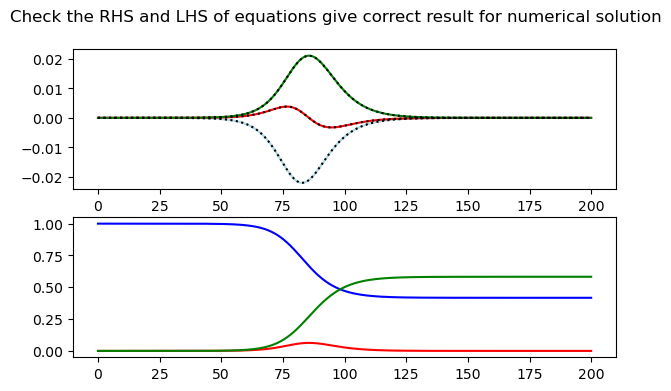

In [188]:
n_points = 1001

t_num = torch.linspace(0, n_days, n_points)

sol = solve_ivp(SIR_model_num, [t_num[0], t_num[-1]], y0, args=(beta_SIR, alpha_SIR), t_eval=t_num, method='LSODA')

S_data = torch.tensor(sol.y[0])
I_data = torch.tensor(sol.y[1])
R_data = torch.tensor(sol.y[2])
print(sol.message)

# Testing whether my brain is broken
dSdt_data = np.gradient(S_data, n_days/n_points)
dIdt_data = np.gradient(I_data, n_days/n_points)
dRdt_data = np.gradient(R_data, n_days/n_points)
rhs_S_data = -beta_SIR * S_data * I_data
rhs_I_data = beta_SIR * S_data * I_data - alpha_SIR * I_data
rhs_R_data = alpha_SIR * I_data

fig, ax = plt.subplots(2, 1, figsize=(7,4))
fig.suptitle('Check the RHS and LHS of equations give correct result for numerical solution')
ax[0].plot(t_num.detach(), dSdt_data, color='lightblue', linestyle='-', alpha=1)
ax[0].plot(t_num.detach(), dIdt_data, color='red', linestyle='-', alpha=1)
ax[0].plot(t_num.detach(), dRdt_data, color='green', linestyle='-', alpha=1)
ax[0].plot(t_num.detach(), rhs_S_data, color='k', linestyle=':')
ax[0].plot(t_num.detach(), rhs_I_data, color='k', linestyle=':')
ax[0].plot(t_num.detach(), rhs_R_data, color='k', linestyle=':')

ax[1].plot(t_num.detach(), S_data, color='blue')
ax[1].plot(t_num.detach(), I_data, color='red')
ax[1].plot(t_num.detach(), R_data, color='green')

# Print the residual
print(torch_MSE_loss(rhs_S_data.clone().detach(), torch.tensor(dSdt_data)))
print(torch_MSE_loss(rhs_I_data.clone().detach(), torch.tensor(dIdt_data)))
print(torch_MSE_loss(rhs_R_data.clone().detach(), torch.tensor(dRdt_data)))

tensor(0.0103, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0103, dtype=torch.float64, grad_fn=<MseLossBackward0>)


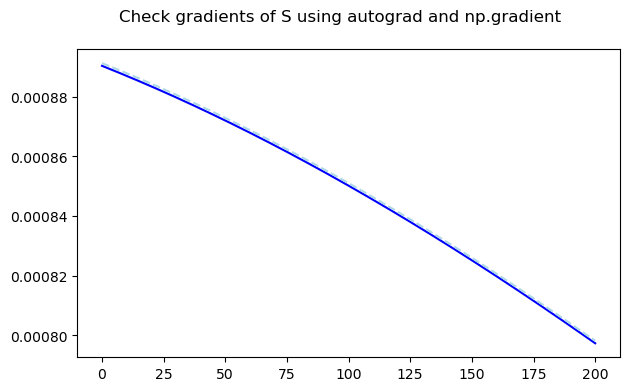

In [189]:
# Check that numpy.gradient gives same result as network through autograd
t = torch.linspace(0, n_days, n_points, requires_grad=True, dtype=torch.double).view(-1,1)
t = t / 1000.0
S_net, I_net, R_net = net_cpu(t)
dSdt_autograd =  1/1000*torch.autograd.grad(S_net, t, grad_outputs=torch.ones_like(S_net), create_graph=True)[0]

t = t*1000.0
dSdt_npgrad = np.gradient(S_net.detach().reshape(-1), n_days/n_points)

fig, ax = plt.subplots(1, 1, figsize=(7,4))
fig.suptitle('Check gradients of S using autograd and np.gradient')
ax.plot(t.detach(), dSdt_autograd.detach(), color='blue')
ax.plot(t.detach(), dSdt_npgrad, color='lightblue', linestyle='--')

print(torch_MSE_loss(dSdt_autograd, -beta_SIR * S_net * I_net))
print(torch_MSE_loss(torch.tensor(dSdt_npgrad).view(-1,1), -beta_SIR * S_net * I_net))

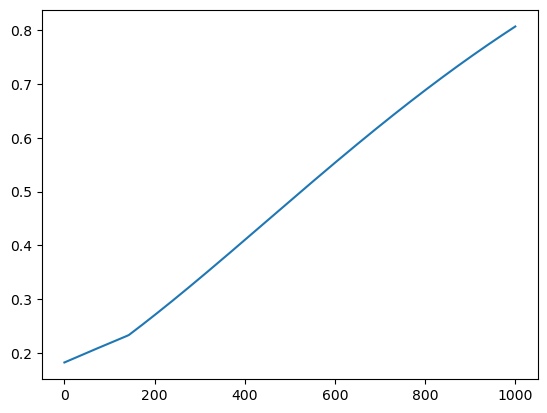

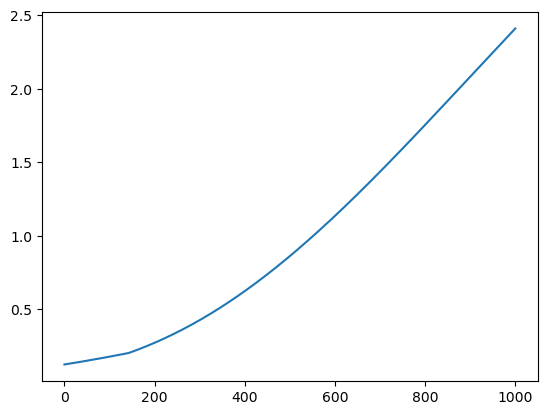

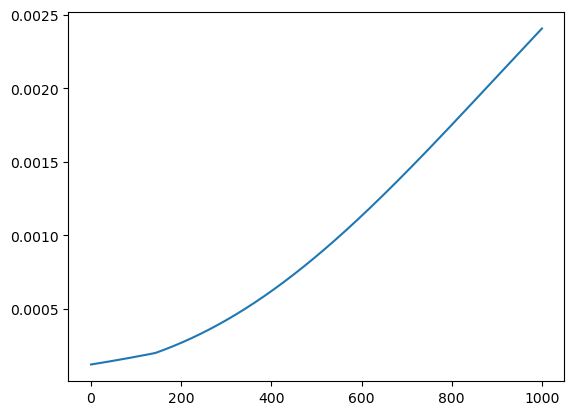

In [190]:
res = residual.to('cpu').detach()

plt.figure()
plt.plot(res)

k = 2
c = 0
expected_value = torch.mean(res**k)
p_x = res**k/expected_value + c
A = torch.sum(p_x)
p_x_wavy = p_x / A 
plt.figure()
plt.plot(p_x)


plt.figure()
plt.plot(p_x_wavy)

In [191]:
xx = p_x_wavy
a = torch.linspace(0,1000,1001).long()
p = p_x_wavy.squeeze().cumsum(0)
idx = torch.tensor([torch.searchsorted(p, torch.rand(1)) for _ in range(100000)])
samples = a[idx]

(0.0, 1000.0)

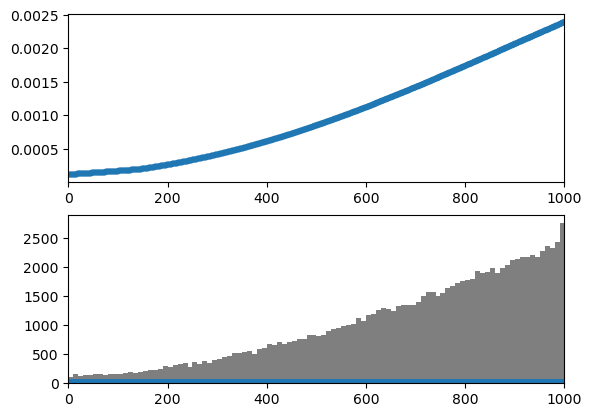

In [192]:
fig, ax = plt.subplots(2,1)
ax[0].plot(p_x_wavy, linestyle='', marker='.')
ax[0].set_xlim(0,1000)
ax[1].plot(samples, np.repeat(1.0, len(samples)), linestyle='', marker='x')
ax[1].hist(samples, bins=100, color='k', alpha=0.5)
ax[1].set_xlim(0,1000)